In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
data = pd.read_csv('developers.csv')

In [9]:
data['year_quarter'] = data['year'].astype(str) + '-Q' + data['quarter'].astype(str)

In [10]:
pivot_data = data.pivot_table(index='iso2_code', columns='year_quarter', values='developers', aggfunc='sum')

In [22]:
top_countries = pivot_data.sum(axis=1).nlargest(4).index
top_countries

Index(['US', 'CN', 'IN', 'BR'], dtype='object', name='iso2_code')

In [39]:
colors_and_markers = {
    'US': {'color': 'blue', 'marker': '^'},  
    'CN': {'color': 'orange', 'marker': 'x'},  
    'IN': {'color': 'green', 'marker': 'o'},  
    'BR': {'color': 'red', 'marker': 's'}, 
}

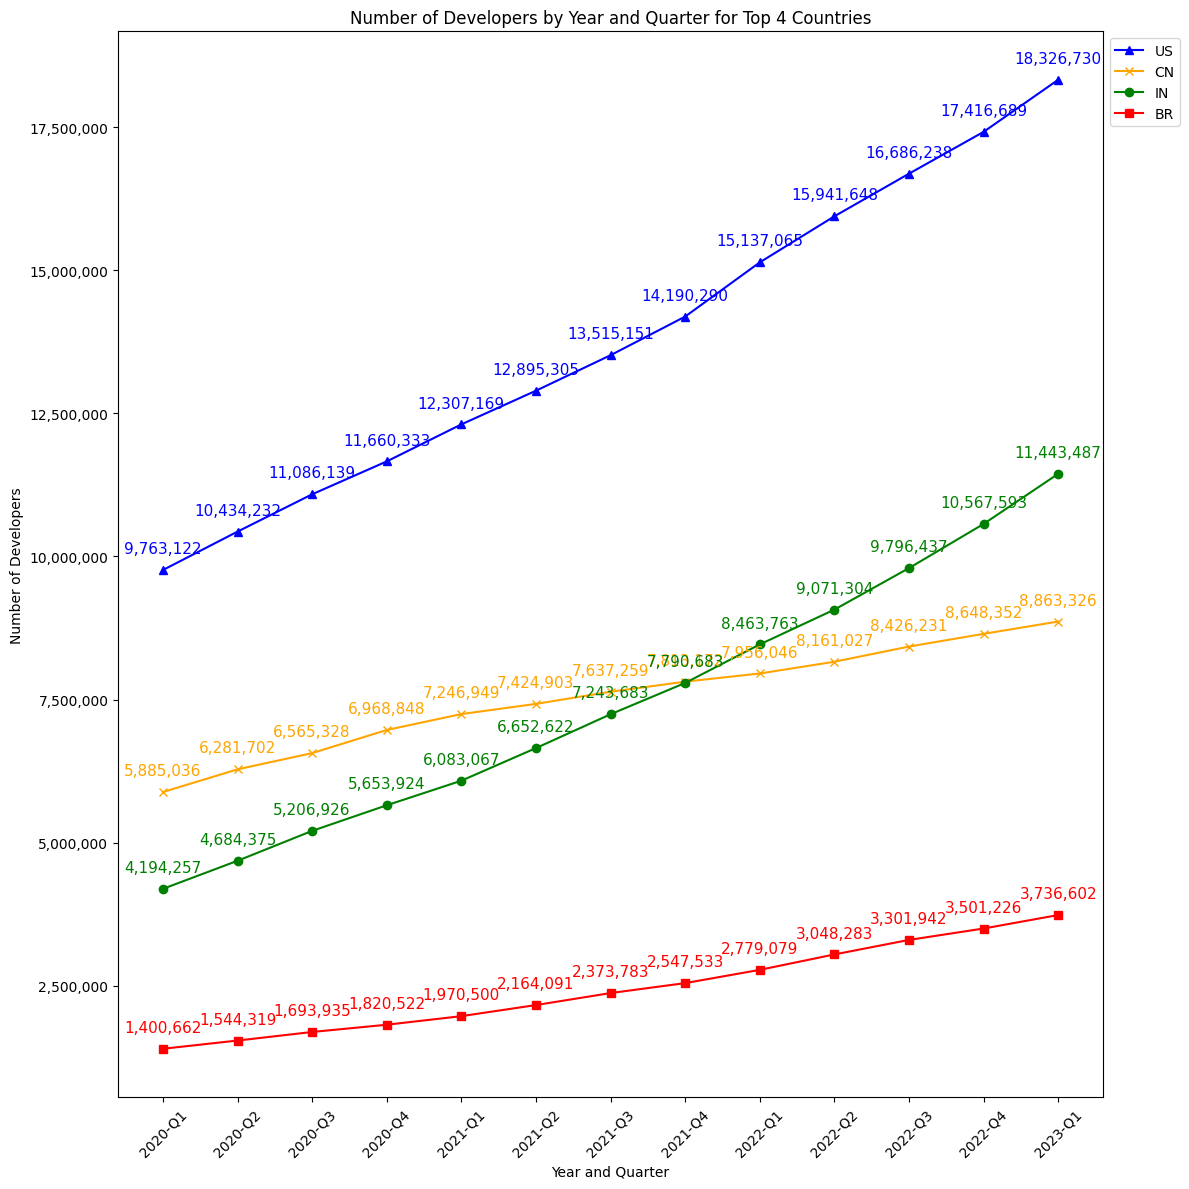

In [52]:
plt.figure(figsize=(12, 12))

for country in top_countries:
    plt.plot(pivot_data.columns, pivot_data.loc[country], 
             marker=colors_and_markers[country]['marker'], 
             color=colors_and_markers[country]['color'], 
             label=country)
    
    for x, y in zip(pivot_data.columns, pivot_data.loc[country]):
        plt.annotate(f'{y:,.0f}', 
                     xy=(x, y), 
                     xycoords='data', 
                     xytext=(0, 10), 
                     textcoords='offset points', 
                     ha='center', 
                     va='bottom',
                     color=colors_and_markers[country]['color'],
                     fontsize=11)


plt.xticks(rotation=45)
plt.xlabel('Year and Quarter')
plt.ylabel('Number of Developers')
plt.title('Number of Developers by Year and Quarter for Top 4 Countries')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)


ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

plt.tight_layout()
plt.show()
